In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import numpy as np
import sklearn
from platform import python_version
from ydata_profiling import ProfileReport
import warnings

In [129]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [130]:
# customizing seaborn theme and style
custom_style = {
    "axes.facecolor": "#f0f0f0",   # Background color
    "axes.edgecolor": "#000000",    # Axes edge color
    "axes.labelcolor": "#000000",   # Label color
    "xtick.color": "#000000",       # X-axis tick color
    "ytick.color": "#000000",       # Y-axis tick color
    "text.color": "#000000",        # Text color
    "axes.titlecolor": "#000000",   # Title color
    "figure.facecolor": "#f0f0f0",  # Figure background color
    "axes.spines.top": False,       # Remove top spine
    "axes.spines.right": False,     # Remove right spine
}

# Set the custom style
sns.set_style("ticks", rc=custom_style)

In [131]:
DATA_PATH = '../data/Mall_Customers.csv'

In [132]:
df = pd.read_csv(DATA_PATH)
print(f'Shape of the data: {df.shape}')
df.head()

Shape of the data: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [133]:
# we don't have null values in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [134]:
# changing pandas format options of this cell
with pd.option_context("display.float_format", "{:.2f}".format):
    display(df.describe())

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


In [135]:
# describe of the gender column: most frequent class is female, there are only two classes, male and female
df.describe(exclude="number")

,Gender
count,200
unique,2
top,Female
freq,112


In [136]:
# generating a profile report to quickly analyze the dataset
profile = ProfileReport(df)
PROFILE_REPORT_PATH = "../reports/exploratory_data_analysis.html"
profile.to_file(PROFILE_REPORT_PATH)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

From the profile report we found:
1. There are outliers in the annual income feature.
2. The age and the spending score seems to have correlation (when the age increases, the spending score decreases)
3. Analyzing the scatter plot between the annual income and the spending score we can see possibly 5 groups of data

In [137]:
# dropping the CustomerID column as this has no meaningfull information for the analysis
df = df.drop(columns="CustomerID", axis=1)

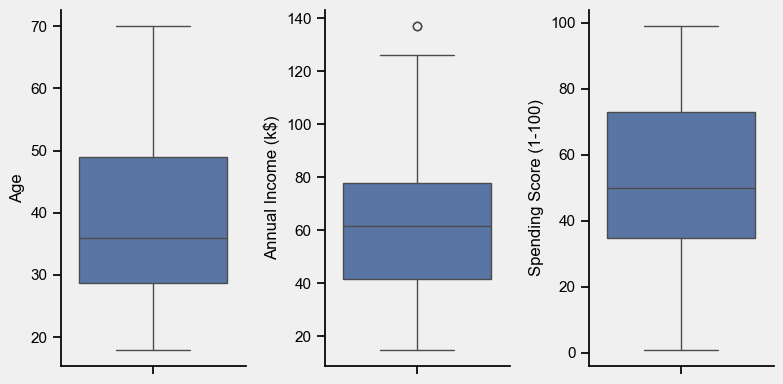

In [138]:
# boxplot for each numerical feature
fig, axs = plt.subplots(ncols=3, figsize=(8,4), tight_layout=True)

for ax, col in zip(axs, df.select_dtypes('number').columns):
    sns.boxplot(data=df, y=col, ax=ax)

plt.show()

Outliers in the annual income as per the boxplot above.

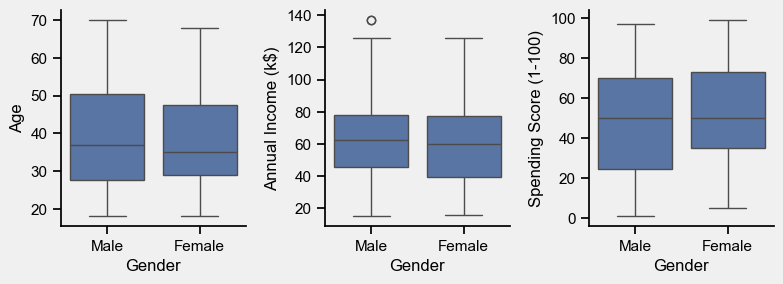

In [139]:
fig, axs = plt.subplots(ncols=3, figsize=(8,3), tight_layout=True)

for ax, col in zip(axs, df.select_dtypes('number').columns):
    sns.boxplot(data=df, x='Gender', y=col, ax=ax)

plt.show()

No diference between gender and any numeric features.

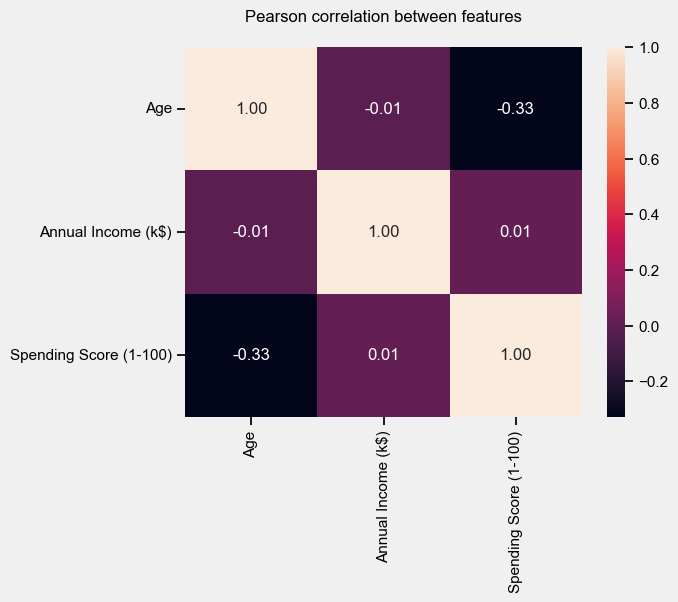

In [149]:
# pearson correlation between numerical features
fig, ax = plt.subplots()

sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', ax=ax)
ax.set_title('Pearson correlation between features\n')

plt.show()

As expected in the scatter plot, the spending score has negative correlation with the age.

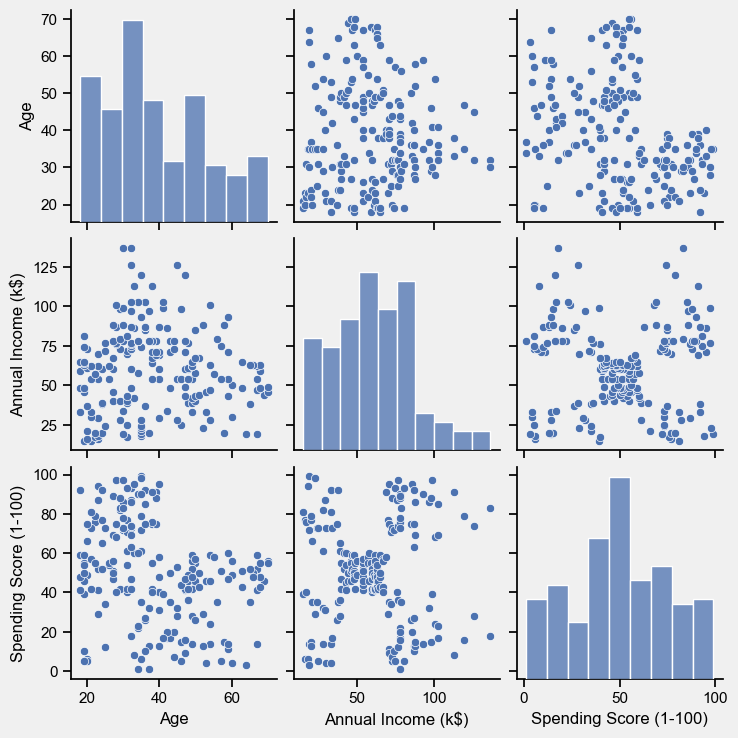

In [151]:
sns.pairplot(df);

A lot of those information are also in the pofiling report. As we can see again, spending score and annual income shows around 5 groups. One in the middle and 4 around. More details about the possible 5 clusters below.

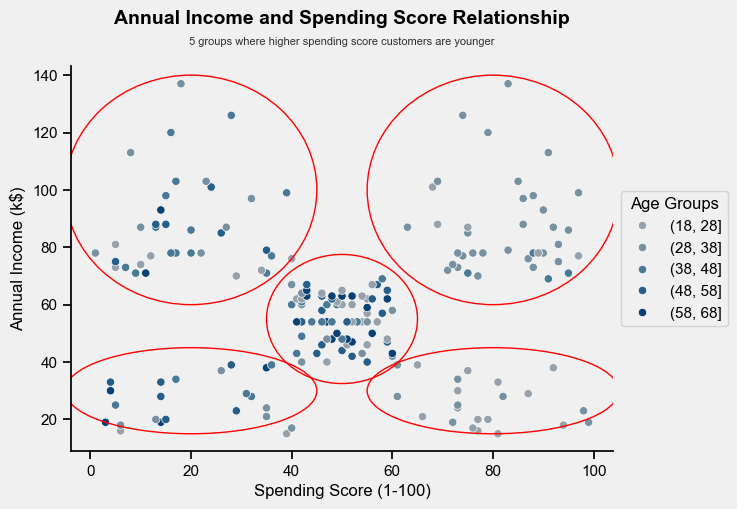

In [171]:
# Create a custom palette with darker shades of blue
custom_palette = sns.color_palette("Blues", 5)  # Generate fewer shades
dark_custom_palette = [(color[0] * 0.7, color[1] * 0.7, color[2] * 0.7) for color in custom_palette]  # Adjust brightness

fig, ax = plt.subplots(figsize=(7,5))
scatterplot = sns.scatterplot(
    data=df, 
    x='Spending Score (1-100)', 
    y='Annual Income (k$)', 
    hue=pd.cut(df['Age'], bins=np.arange(min(df['Age']), max(df['Age']), step=10)),
    palette=dark_custom_palette
)

# Adding possible clusters
xywh = [(20,100,50,80), (80,100,50,80), (50,55,30,45), (20,30,50,30), (80,30,50,30),]
for x, y, w, h in xywh:
    ellip = patches.Ellipse((x, y), width=w, height=h, color='red', fill=False)
    ax.add_patch(ellip)

# Set the legend outside the plot
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Age Groups')

ax.text(x=0.5, y=1.1, s='Annual Income and Spending Score Relationship', fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='5 groups where higher spending score customers are younger', fontsize=8, alpha=0.8, ha='center', va='bottom', transform=ax.transAxes)

plt.show()


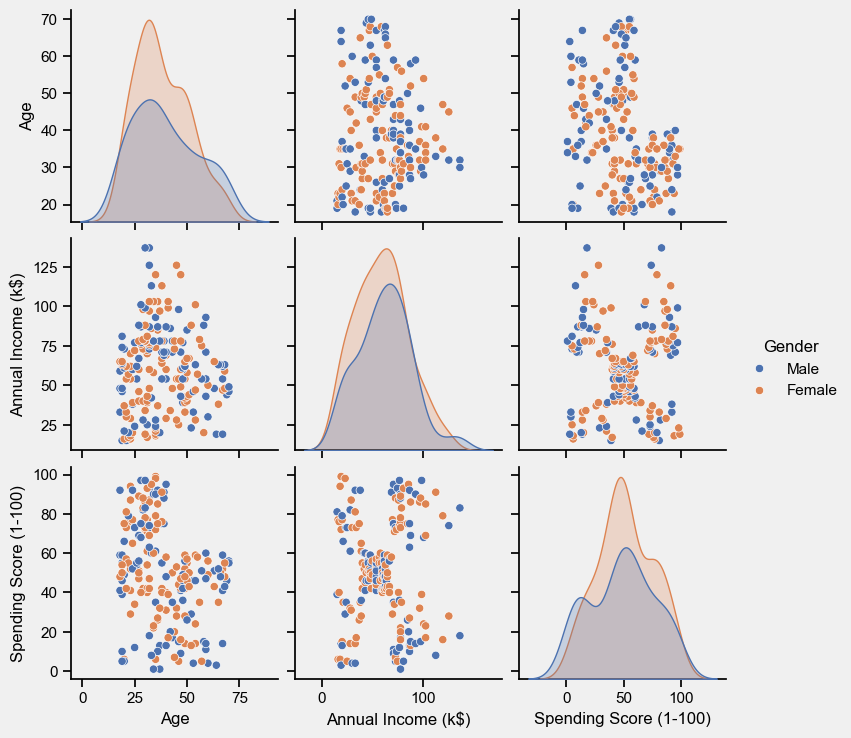

In [143]:
display(sns.pairplot(df, diag_kind='kde', hue='Gender'));

As we saw in the profiling report again, we can't see any difference in the gender.